### Setup

Import Caffe and the usual modules.

In [1]:
import sys
import os
import numpy as np
import skimage.io
import math
import matplotlib.pyplot as plt

%matplotlib inline

#plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make sure that caffe is on the python path:
caffe_root = '../../'  # this file is expected to be in {caffe_root}/examples/triplet_LINEMOD
sys.path.insert(0, caffe_root + 'python')

import caffe

### Load the trained net 

Load the model definition and weights and set to GPU mode TEST phase computation with input scaling.

In [2]:
MODEL_FILE = '3d_triplet.prototxt'
PRETRAINED_FILE = 'linemod_triplet_1_iter_1200000.caffemodel' 
caffe.set_device(7)
caffe.set_mode_gpu()
net = caffe.Net(MODEL_FILE, PRETRAINED_FILE, caffe.TEST)

### Load template images and extract their feature vectors

In [3]:
from struct import unpack
def swap_endian32(val):
    return (((val << 24) & 0xFF000000) |
            ((val << 8) & 0x00FF0000) |
            ((val >> 8) & 0x0000FF00) |
            ((val >> 24) & 0x000000FF))

TMPL_DATA_FILE = '/home/hy/wb/LINEMOD/_tmpl/binary_image'
TMPL_LABEL_FILE = '/home/hy/wb/LINEMOD/_tmpl/binary_label'
data_channel = 3
data_class = 15

with open(TMPL_DATA_FILE, 'rb') as f:
    data_magic = unpack('i', f.read(4))[0]
    data_magic = swap_endian32(data_magic)
    if data_magic != 2051:
        print('Invalid binary data file\n')
        sys.exit()
    n = unpack('i', f.read(4))[0]
    n = swap_endian32(n)
    rows = unpack('i', f.read(4))[0]
    rows = swap_endian32(rows)
    cols = unpack('i', f.read(4))[0]
    cols = swap_endian32(cols)
    raw_tmpl_data = np.fromstring(f.read(n*data_channel*64*64), dtype=np.uint8)
    print('template images size:%d rows:%d cols:%d\n' %(n, rows, cols))
    
with open(TMPL_LABEL_FILE, 'rb') as f:
    label_magic = unpack('i', f.read(4))[0]
    label_magic = swap_endian32(label_magic)
    if label_magic != 2050:
        print('Invalid binary label file\n')
        sys.exit()
    n_l = unpack('i', f.read(4))[0]
    n_l = swap_endian32(n_l)
    tmpl_labels_list = []
    for i in range(n_l):
        label_id_position = f.seek(8+i*4*4,0)
        label_id_val = unpack('i', f.read(4))[0]
        tmpl_labels_list.append(label_id_val)
    tmpl_labels_id = np.array(tmpl_labels_list)
    print('template labels size:%d\n' %(n_l))
    
if n != n_l:
    print('Inconsistent data and label\n')
    sys.exit()
    
    
# reshape and preprocess
net.blobs['data'].reshape(n, data_channel, rows, cols)
caffe_tmpl_in = raw_tmpl_data.reshape(n, data_channel, rows, cols) * 0.00390625
tmpl_out = net.forward_all(data=caffe_tmpl_in)
tmpl_feat = tmpl_out['feat'] # feature array for all template images

template images size:5115 rows:64 cols:64

template labels size:5115



### KNN for classification and pose estiamtion

In [4]:
LINEMOD_ROOT = '/home/hy/wb/LINEMOD'
OBJ_NAMES = ['ape', 'benchviseblue', 'bowl', 'cam', 'can', 'cat', 'cup', 'driller', 'duck', 
             'eggbox', 'glue', 'holepuncher', 'iron', 'lamp', 'phone']

#euclidean distance
def eu_distance(a, b, pow_order=2):
    ab_diff = np.subtract(a, b)
    ab_diff_p = np.power(ab_diff, pow_order)
    dist = np.sum(ab_diff_p)
    if dist==0:
        return 0
    else:
        return math.sqrt(dist)

from collections import OrderedDict
#brute force KNN
def KNN(point, points, k=1):
    points_num = points.shape[0]
    if k>points_num:
        print('The number of neighbors is out of range.')
        k = points_num
    
    tmp_dists = {}
    for i in range(points_num):
        dist = eu_distance(point, points[i,:])
        tmp_dists[str(i)] = dist
    nn_dists = OrderedDict(sorted(tmp_dists.items(), key=lambda t:t[1]))
    
    knn_ids = []
    knn_vals = []
    counter = 0
    for key,val in nn_dists.items():
        if counter<k:
            knn_ids.append(int(key))
            knn_vals.append(val) 
            counter = counter+1
        else:
            break
   
    return knn_ids, knn_vals

def triplet_classifer(knn_ids, class_num, tmpl_labels_id):
    k = len(knn_ids)
    knn_class_ids = []
    for i in range(k):
        point_id = knn_ids[i]
        knn_class_ids.append(tmpl_labels_id[point_id])
    cls_prob = []
    for i in range(class_num):
        curr_num = knn_class_ids.count(i)
        curr_prob = 100.0*curr_num/k
        cls_prob.append(curr_prob)
    max_prob_id = cls_prob.index(max(cls_prob))
    
    return max_prob_id, cls_prob

def triplet_pose_estimate(best_class_id, knn_ids, tmpl_labels_id, tmpl_poses_list):
    k = len(knn_ids)
    knn_class_ids = []
    for i in range(k):
        point_id = knn_ids[i]
        knn_class_ids.append(tmpl_labels_id[point_id])
    best_cls_first_point_ = knn_class_ids.index(best_class_id)
    best_cls_first_point_id = knn_ids[best_cls_first_point_]
    
    if best_class_id!=int(tmpl_poses_list[best_cls_first_point_id][0]):
        print('Label inconsistent.')
    subdir = tmpl_poses_list[best_cls_first_point_id][1]
    nn_img_name = tmpl_poses_list[best_cls_first_point_id][2]
    
    al_pose_file_path = '{0}/{1}/cropped/{2}_view_al.txt'.format(LINEMOD_ROOT,OBJ_NAMES[best_class_id],subdir)
    al_poses = [[x for x in line.strip().split(' ')] for line in open(al_pose_file_path).readlines()]
    for i in range(len(al_poses)):
        if al_poses[i][0]==nn_img_name:
            return float(al_poses[i][1]),float(al_poses[i][2]),float(al_poses[i][3]),float(al_poses[i][4])
    
    return None

def triplet_ground_truth_pose(point_id, test_poses_list):
    class_id = int(test_poses_list[point_id][0])
    subdir = test_poses_list[point_id][1]
    img_name = test_poses_list[point_id][2]
    al_pose_file_path = '{0}/{1}/cropped/{2}_view_al.txt'.format(LINEMOD_ROOT,OBJ_NAMES[class_id],subdir)
    al_poses = [[x for x in line.strip().split(' ')] for line in open(al_pose_file_path).readlines()]
    for i in range(len(al_poses)):
        if al_poses[i][0]==img_name:
            return float(al_poses[i][1]),float(al_poses[i][2]),float(al_poses[i][3]),float(al_poses[i][4])
    
    return None

### Sliding windows in a single image

In [5]:
def img2windows(img, win_size):
    pad_size_h = win_size[0]/2
    pad_size_w = win_size[1]/2
    img_c = img.shape[2]
    img_h = img.shape[0]
    img_w = img.shape[1]
    img_rgbhw = np.transpose(img, (2,0,1)) # convert H*W*RGB to RGB*H*W
    img_pad = np.pad(img_rgbhw, ((0,0), (pad_size_h,pad_size_h), (pad_size_w,pad_size_w)), 'constant', constant_values=((0,0),(0,0),(0,0))) # padding
    
    window_imgs_list = []
    window_imgs_shape = (img_h*img_w, img_c, win_size[0], win_size[1])
    for i in range(img_h):
        h_start = i
        h_end = h_start+win_size[0]
        for j in range(img_w):
            w_start = j
            w_end = w_start+win_size[1]
            curr_win = img_pad[:, h_start:h_end, w_start:w_end]
            window_imgs_list.append(curr_win)
    window_imgs = np.array(window_imgs_list)

    return window_imgs

def img2windows2(img, win_size):
    pad_size_h = win_size[0]/2
    pad_size_w = win_size[1]/2
    img_c = img.shape[2]
    img_h = img.shape[0]
    img_w = img.shape[1]
    img_pad = np.pad(img, ((pad_size_h,pad_size_h), (pad_size_w,pad_size_w), (0,0)), 'constant', constant_values=((0,0),(0,0),(0,0))) # padding

    img_new = np.ascontiguousarray(img_pad)
    Y,X,C = img_new.shape
    if win_size[0]%2==0:
        shape = (Y-win_size[0], X-win_size[1], win_size[0], win_size[1], img_c)
    else:
        shape = (Y-win_size[0]+1, X-win_size[1]+1, win_size[0], win_size[1], img_c)
    strides = img_new.itemsize * np.array([X*img_c, img_c, X*img_c, img_c, 1])

    window_imgs =  np.lib.stride_tricks.as_strided(img_new, shape=shape, strides=strides)
    window_imgs_new = np.transpose(window_imgs, (0,1,4,2,3))
    window_imgs_new = window_imgs_new.reshape((shape[0]*shape[1], shape[4], shape[2], shape[3]))
    return  window_imgs_new

### Detect on a single image

In [6]:
img_path = '/home/hy/wb/LINEMOD/color1_640.jpg'
img = skimage.io.imread(img_path)

win_size = (64,64)
sliding_wins = img2windows(img, win_size) * 0.00390625

batch_num= img.shape[0]
batch_size = img.shape[1]
net.blobs['data'].reshape(batch_size, data_channel, win_size[0], win_size[1]) # change the data shape on the fly
all_feat_out = []
for b in range(batch_num):
    batch_out = net.forward_all(data=sliding_wins[b*batch_size:(b+1)*batch_size,:,:,:])
    all_feat_out.extend(batch_out['feat'].copy())
all_feat_out = np.asarray(all_feat_out)
print('all feat shape {}'.format(all_feat_out.shape))

all feat shape (307200, 16)


max 0.970342278481 position 253 498


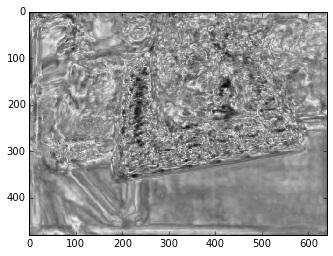

In [7]:
# use all templates
K = 1
dist_map = np.zeros((img.shape[0], img.shape[1]), dtype=np.float32)
for i in range(batch_num):
    for j in range(batch_size):
        knn_ids, knn_vals = KNN(all_feat_out[i*batch_size+j,:], tmpl_feat, k=K)
        dist_map[i,j] = math.exp(-knn_vals[0])

max_position = np.argmax(dist_map)
max_val = np.amax(dist_map)
print('max {} position {} {}'.format(max_val, max_position/batch_size, max_position%batch_size))

plt.imshow(dist_map)

max 0.952608466148 position 201 612


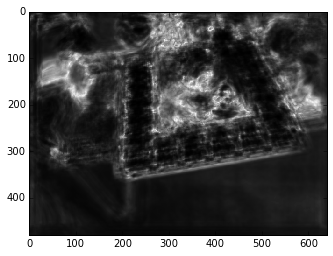

In [8]:
# just use the correct templates
K = 1
dist_map = np.zeros((img.shape[0], img.shape[1]), dtype=np.float32)
for i in range(batch_num):
    for j in range(batch_size):
        knn_ids, knn_vals = KNN(all_feat_out[i*batch_size+j,:], tmpl_feat[5*341:6*341,:], k=K)
        dist_map[i,j] = math.exp(-knn_vals[0])

max_position = np.argmax(dist_map)
max_val = np.amax(dist_map)
print('max {} position {} {}'.format(max_val, max_position/batch_size, max_position%batch_size))

plt.imshow(dist_map)